In [207]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
from skimage.feature import peak_local_max
from skimage.filters import gaussian
from ultralytics import SAM
import os
import glob


In [384]:
# Usage
scan_dir = "merged_scan_50"
image_dir = "099_perspective"


anomaly_mask = np.load(f"results/anomaly_masks/exp_train400_coreset0.3/{scan_dir}_{image_dir}_mask.npy")
original_image_path = f"masonry_dataset/wall/test/defect/{scan_dir}_{image_dir}.png"
original_point_path = f"bucket/analysis-pipeline-data/National_Highways/Wheatley_Tunnel/data_intermediate/figures/dataset_depth_image/20250617/{scan_dir}/{image_dir}.npz"
original_image = cv2.imread(original_image_path)


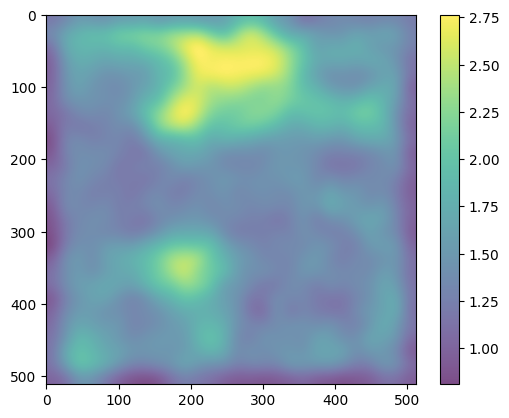

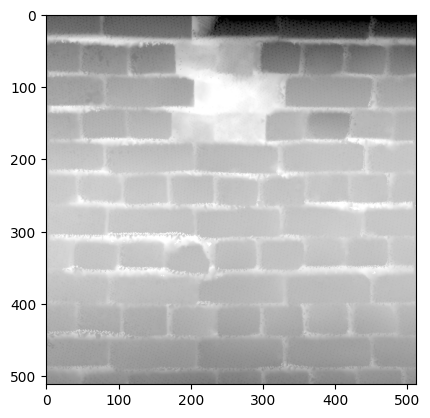

In [385]:
plt.imshow(anomaly_mask, alpha=0.7)
plt.colorbar()
plt.show()

# Show contour lines at different anomaly score levels
plt.imshow(original_image)  # Your background image
plt.show()


In [332]:
def get_contour_bounding_boxes(contours, padding=10):
    """
    Extract bounding boxes from matplotlib contours for SAM prompts

    Args:
        contours: matplotlib contour object from plt.contour()
        padding: pixels to add around each bounding box

    Returns:
        list: List of bounding boxes in [x1, y1, x2, y2] format for SAM
    """
    bounding_boxes = []

    for level_idx in range(len(contours.levels)):
        level_paths = contours.collections[level_idx].get_paths()

        for path in level_paths:
            if len(path.vertices) < 3:
                continue

            vertices = path.vertices

            # Get min/max coordinates
            x_min = vertices[:, 0].min()
            x_max = vertices[:, 0].max()
            y_min = vertices[:, 1].min()
            y_max = vertices[:, 1].max()

            # Add padding
            x1 = max(0, int(x_min - padding))
            y1 = max(0, int(y_min - padding))
            x2 = int(x_max + padding)
            y2 = int(y_max + padding)

            # SAM format: [x1, y1, x2, y2]
            bbox = [x1, y1, x2, y2]
            bounding_boxes.append(bbox)

    return bounding_boxes

In [350]:
def merge_contained_bounding_boxes(bounding_boxes):
    """
    Remove bounding boxes that are fully contained within other bounding boxes.
    Returns only the 'parent' bounding boxes.

    Args:
        bounding_boxes: List of bounding boxes in [x1, y1, x2, y2] format

    Returns:
        List of parent bounding boxes (those that contain others or are not contained)
    """
    if not bounding_boxes:
        return []

    def is_contained(bbox_a, bbox_b):
        """Check if bbox_a is fully contained within bbox_b"""
        x1_a, y1_a, x2_a, y2_a = bbox_a
        x1_b, y1_b, x2_b, y2_b = bbox_b

        return (x1_b <= x1_a and y1_b <= y1_a and
                x2_a <= x2_b and y2_a <= y2_b)

    parent_boxes = []

    for i, bbox_candidate in enumerate(bounding_boxes):
        is_child = False

        # Check if this bounding box is contained within any other
        for j, bbox_other in enumerate(bounding_boxes):
            if i != j and is_contained(bbox_candidate, bbox_other):
                is_child = True
                break

        # If not contained within any other box, it's a parent
        if not is_child:
            parent_boxes.append(bbox_candidate)

    return parent_boxes


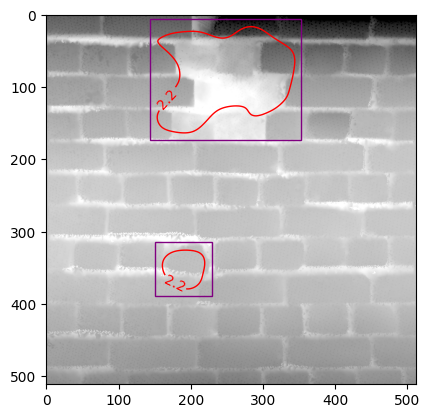

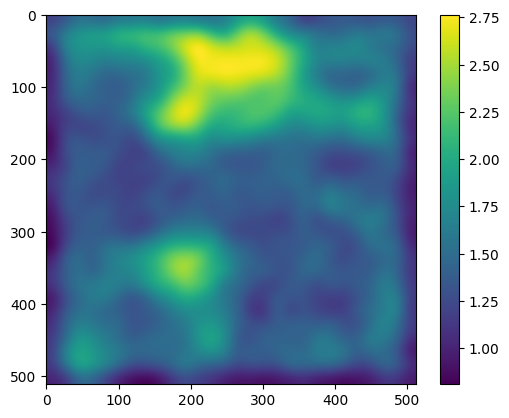

In [386]:
import numpy as np
import cv2
from matplotlib.path import Path
import copy

# Get contours and extract geometry before visualisation
contours = plt.contour(anomaly_mask, levels=[2.2], colors='red', linewidths=1)
bounding_boxes = get_contour_bounding_boxes(contours, padding=10)

bounding_boxes = merge_contained_bounding_boxes(bounding_boxes)

# Visualize
plt.imshow(original_image)
plt.clabel(contours, inline=True)  # Add labels showing the levels

for i, bbox in enumerate(bounding_boxes):
    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    rect = plt.Rectangle((x1, y1), width, height,
                        fill=False, color='purple', linewidth=1)
    plt.gca().add_patch(rect)

plt.show()

plt.imshow(anomaly_mask)
plt.colorbar()
plt.show()



In [382]:
from ultralytics import SAM
import cv2
import numpy as np
import matplotlib.pyplot as plt

sam_model = SAM('sam2.1_l.pt')


0: 512x512 1 0, 1 1, 69.7ms
Speed: 1.4ms preprocess, 69.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /home/tom_hill_joltsynsor_com/patchcore-inspection/runs/segment/predict23


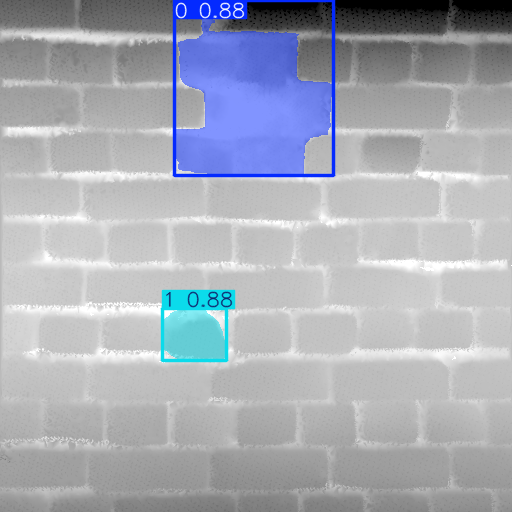

In [387]:
def run_sam_on_bboxes(image_path, bboxes):
    """Simple function to run SAM on hotspot points"""

    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert points to numpy array
    points = np.array(bboxes)

    labels = np.ones(len(bboxes))


    # Run SAM
    results = sam_model(image_rgb, bboxes=bboxes, labels=labels, imgsz=512, save=True)

    return image_rgb, results

_, results = run_sam_on_bboxes(original_image_path, bounding_boxes)
results[0].show()
